# Análisis de sentimiento menciones “Renaper”



In [1]:
# Importo las librerias que voy a usar

import pandas as pd
import tweepy
from time import sleep
from datetime import datetime
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import re
import string
import json
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [124]:
# Diccionarios que voy a usar mas adelante

positivos = []
negativos = []
neutros = []
pos = []
neg = []
neu = []
stem_pos = []
stem_neg = []
stem_neu = []
wordCountPos = []
wordCountNeg = []
wordCountNeu = []
filtered_pos = []
filtered_neg = []
filtered_neu = []
countsPos = {}
countsNeg = {}
countsNeu = {}
countsnombres = {}

In [3]:
# Autentifico credenciales para twitter

consumer_key = "xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"
consumer_secret = "xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"
access_token = "xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"
access_token_secret = "xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

In [32]:
# Busco apariciones de la palabra Renaper en twitter y guardo todo en un Dataframe

text_query = 'renaper'
count = 5000
try:
 tweets = tweepy.Cursor(api.search,q=text_query, 
                              since="2019-12-10",
                              until="2020-09-22",
                        tweet_mode='extended').items(count)
 
 tweets_list = [[tweet.created_at, tweet.user.name, tweet.full_text] for tweet in tweets]
 
 tweets_df2 = pd.DataFrame(tweets_list)
 
except BaseException as e:
    print('failed on_status,',str(e))
    time.sleep(3)

In [33]:
tweets_df2.to_csv('renaper_22_9.csv', index=False)

# Pre Procesamiento

In [11]:
# Reabro el data frame

df = pd.read_csv('renaper_22_9.csv')
pd.options.display.max_colwidth = 2000

In [12]:
# Paso los campos de datos a formato date para poder separarlos

df['Dates'] = pd.to_datetime(df.iloc[:,0]).dt.date 
df['Time'] = pd.to_datetime(df.iloc[:,0]).dt.time 
df = df.drop(df.columns[[0]], axis=1)
df.columns = ['Nombre', 'texto', 'dates', 'time']

In [13]:
# Ejemplo de los textos recopilados

df.head()

,Nombre,texto,dates,time
0,Mariano Amores,@renaper_ar Gracias,2020-09-21,23:04:39
1,jesus,@renaper_ar Hola buenas tardes en el partido de Avellaneda donde puedo tramitar el dni o en la oficinas de paseo colon ya que dice que no hay turnos disponibles mediante mi argentina.,2020-09-21,22:45:10
2,RENAPER,"@Junior13834418 Buenas tardes, le pedimos por favor nos remita su consulta por privado adjuntando sus datos. \n\nMuchas gracias",2020-09-21,22:38:28
3,Junior,@renaper_ar,2020-09-21,22:10:21
4,Junior,@renaper_ar buenas como puedo saber si mi dni salió de fábrica. Ya ase un año ke me dicen que está en fábrica y lo necesito para poder tramitar en definitivo y muchos otros trámites por favor si alguien me puede desir algo.,2020-09-21,22:09:40


In [14]:
# Paso dates a datatime para poder agruparlo

df['dates'] = pd.to_datetime(df['dates'])

In [15]:
df['dates'].groupby([df.dates.dt.year, df.dates.dt.month]).agg('count') 

dates  dates
2020   9        433
Name: dates, dtype: int64

In [16]:
# Uso esta funcion para remover caracteres de español

def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace('¡', ' ')
        text = text.replace('á', 'a')
        text = text.replace('é', 'e')
        text = text.replace('í', 'i')
        text = text.replace('ó', 'o')
        text = text.replace('ú', 'u')
        text = text.replace('ñ', 'n')
        text = text.replace('  ', ' ')
        text = text.lower()
    return text

In [17]:
# Llamo la funcion y lo guardo en una nueva columna

df["new_column"] = df['texto'].apply(remove_punctuations)

In [18]:
# Chequeo como quedo la columna

df["new_column"].head()

0                                                                                                                                                                                                                @renaper_ar gracias
1                                            @renaper_ar hola buenas tardes en el partido de avellaneda donde puedo tramitar el dni o en la oficinas de paseo colon ya que dice que no hay turnos disponibles mediante mi argentina.
2                                                                                                    @junior13834418 buenas tardes, le pedimos por favor nos remita su consulta por privado adjuntando sus datos. \n\nmuchas gracias
3                                                                                                                                                                                                                        @renaper_ar
4    @renaper_ar buenas como puedo saber si mi dni salio de fabrica. ya ase un ano k

In [19]:
# Guardo dos csv, uno para analizar con la columna sola (que va a AWS ), otro con los nombre de usuarios y otro full

df["Nombre"].to_csv('Usuarios.csv')
df["new_column"].to_csv('AWS.csv')
df.to_csv('renaper_2.csv', index=False)

In [20]:
# Abro el csv con todo y el del analisis de AWS

df = pd.read_csv('renaper_2.csv')
data_df = pd.read_json('salidaAWS.json', lines=True)

# Analisis


In [24]:
# desdoblo los campos que estan en el diccionario de scores para juntarlo con el csv original

data = data_df['SentimentScore']
data2 = pd.json_normalize(data)

In [25]:
data2.reset_index(level=0, inplace=True) 

In [26]:
analisis = pd.merge(data_df, data2,left_on='Line', right_on='index')

In [27]:
analisis = analisis.drop(['SentimentScore','File'], axis=1)

In [29]:
# Asi se ve el data del Analisis que hicimos en AWS

analisis.head(10)

,Line,Sentiment,index,Mixed,Negative,Neutral,Positive
0,2,NEUTRAL,2,0.000043,0.000288,0.789279,0.210390
1,8,NEUTRAL,8,0.000021,0.084602,0.893718,0.021659
2,13,NEUTRAL,13,0.000090,0.019940,0.773471,0.206500
3,20,NEGATIVE,20,0.000006,0.310837,0.677558,0.011599
4,21,NEUTRAL,21,0.000018,0.839272,0.158013,0.002697
5,26,NEUTRAL,26,0.000024,0.199855,0.763989,0.036132
6,46,NEUTRAL,46,0.015660,0.019259,0.932077,0.033004
7,51,POSITIVE,51,0.015660,0.019259,0.932077,0.033004
8,52,NEUTRAL,52,0.300823,0.055039,0.410655,0.233483
9,62,NEUTRAL,62,0.015660,0.019259,0.932077,0.033004


In [30]:
df.reset_index(level=0, inplace=True) 

In [31]:
# Junto los dos DF

completo = pd.merge(df, analisis,left_on='index', right_on='Line')

In [34]:
# Quito las columnas que ya no sirven

completo = completo.drop(['index_x','Line','Line','index_y'], axis=1)

In [35]:
# Asi vamos hasta aca

completo.head()

,level_0,Nombre,texto,dates,time,new_column,Sentiment,Mixed,Negative,Neutral,Positive
0,0,Mariano Amores,@renaper_ar Gracias,2020-09-21,23:04:39,@renaper_ar gracias,NEUTRAL,0.001309,0.340798,0.599819,0.058075
1,1,jesus,@renaper_ar Hola buenas tardes en el partido de Avellaneda donde puedo tramitar el dni o en la oficinas de paseo colon ya que dice que no hay turnos disponibles mediante mi argentina.,2020-09-21,22:45:10,@renaper_ar hola buenas tardes en el partido de avellaneda donde puedo tramitar el dni o en la oficinas de paseo colon ya que dice que no hay turnos disponibles mediante mi argentina.,NEUTRAL,0.000012,0.081171,0.892657,0.026161
2,2,RENAPER,"@Junior13834418 Buenas tardes, le pedimos por favor nos remita su consulta por privado adjuntando sus datos. \n\nMuchas gracias",2020-09-21,22:38:28,"@junior13834418 buenas tardes, le pedimos por favor nos remita su consulta por privado adjuntando sus datos. \n\nmuchas gracias",NEUTRAL,0.000043,0.000288,0.789279,0.210390
3,3,Junior,@renaper_ar,2020-09-21,22:10:21,@renaper_ar,NEUTRAL,0.000003,0.880894,0.115747,0.003356
4,4,Junior,@renaper_ar buenas como puedo saber si mi dni salió de fábrica. Ya ase un año ke me dicen que está en fábrica y lo necesito para poder tramitar en definitivo y muchos otros trámites por favor si alguien me puede desir algo.,2020-09-21,22:09:40,@renaper_ar buenas como puedo saber si mi dni salio de fabrica. ya ase un ano ke me dicen que esta en fabrica y lo necesito para poder tramitar en definitivo y muchos otros tramites por favor si alguien me puede desir algo.,NEUTRAL,0.000016,0.246102,0.658302,0.095580


In [36]:
completo.to_csv('renaper_3.csv')

In [183]:
full = pd.read_csv('renaper_3.csv')

<BarContainer object of 4 artists>

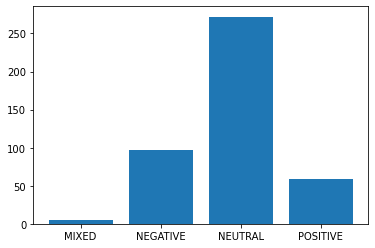

In [188]:
# Cuento cuantos Tweets tengo en cada categoria

recuento = full['texto'].groupby(by=full['Sentiment'], axis=0).count()

barras = pd.DataFrame(recuento)

plt.bar(barras.index, mosaico['texto'])

In [189]:
barras

,texto
Sentiment,
MIXED,5
NEGATIVE,97
NEUTRAL,272
POSITIVE,59


- Como primera opinión, tiendo a pensar que si tomamos en cuenta la cantidad de opiniones neutrales, la cuenta presta un servicio sin mucha opinión de parte de los usuarios.
- También podemos notar que la cantidad de comentarios negativos casi duplica a los positivos.

In [76]:
# Separo el Dataframe en 3 de acuerdo al "Sentimiento"

positivas = full[full["Sentiment"] == 'POSITIVE']
negativas = full[full["Sentiment"] == 'NEGATIVE']
neutras = full[full["Sentiment"] == 'NEUTRAL']

In [77]:
# Armo diccionarios con cada categoria y armo otro juego con las palabras originales para los gráficos

In [78]:
pos = [positivas['new_column'] for d in positivas]
pos_sam = [positivas['texto'] for d in positivas]

In [79]:
neg = [negativas['new_column'] for d in negativas]
neg_sam = [negativas['texto'] for d in negativas]

In [80]:
neu = [neutras['new_column'] for d in neutras]
neu_sam = [neutras['texto'] for d in neutras]

In [81]:
# Cargo bibliotecas para textos

import re
from nltk.corpus import stopwords
import nltk
from collections import Counter
#nltk.download('stopwords')
from nltk import word_tokenize
from collections import defaultdict
wordCountStem = defaultdict(int)
from nltk.tokenize import word_tokenize 
import collections
import pprint

In [82]:
# Cargo las stopwords y en diferentes interacciones voy agregando palabras que estan en el TOP50 sin valor 

stop_words = set(stopwords.words('spanish'))
stop_words.update(['co','rt','t','http','ar','ans','pbkff','pzlvrzsv','pzlvrzsv','Counter','@','[',
                  ',','.',':','?','/','https','co','renap','vyy1quylvf','unificarian','si','object','🤦🏻\u200d♀️','!'
                  '//t.co/ds0wjctyce','1','2','3','4','5','6','7','8','...',')','(','q','0','12','!','0','/n','9'])


Las stopwords es el nombre que reciben las palabras sin significado como artículos, pronombres, preposiciones, etc. que son filtradas antes o después del procesamiento de datos en lenguaje natural (texto). A Hans Peter Luhn, uno de los pioneros en recuperación de información, se le atribuye la acuñación de la locución inglesa stop words y el uso del concepto en su diseño. Está controlada por introducción humana y no automática. 

Tokenizar implica separar las palabras de cada uno de los listados para poder analizaar orden y cantidades

In [83]:
# Tokennizo

tokens_pos = nltk.word_tokenize(str(pos))
tokens_neg = nltk.word_tokenize(str(neg))
tokens_neu = nltk.word_tokenize(str(neu))

In [84]:
#Remuevo las StopWords, dejando sólo las que tengan sentido

filtered_pos = [w for w in tokens_pos if not w in stop_words]

In [85]:
filtered_neg = [w for w in tokens_neg if not w in stop_words]  

In [86]:
filtered_neu = [w for w in tokens_neu if not w in stop_words]  

In [90]:
# Cuento las palabras de cada uno y los pongo en orden

for palabra in filtered_pos:
    countsPos.setdefault(palabra, 0)
    countsPos[palabra] = countsPos[palabra] + 1

countsPosEnOrden = collections.Counter(countsPos)

In [91]:
for palabraN in filtered_neg:
    countsNeg.setdefault(palabraN, 0)
    countsNeg[palabraN] = countsNeg[palabraN] + 1

countsNegEnOrden = collections.Counter(countsNeg)


In [92]:
for palabraNN in filtered_neu:
    countsNeu.setdefault(palabraNN, 0)
    countsNeu[palabraNN] = countsNeu[palabraNN] + 1

countsNeuEnOrden = collections.Counter(countsNeu)

In [128]:
cuentaNombre = collections.Counter(nombres)

In [129]:
ordenpos = countsPosEnOrden.most_common()
ordenneg = countsNegEnOrden.most_common()
ordenneu = countsNeuEnOrden.most_common()
ordennom = cuentaNombre.most_common()

In [131]:
# Armo un Dataframe con la cantidad de palabras

ranking1 = pd.DataFrame(ordenpos)
ranking2 = pd.DataFrame(ordenneg)
ranking3 = pd.DataFrame(ordenneu)
ranking4 = pd.DataFrame(ordennom)

ranking = pd.concat([ranking1, ranking2,ranking3,ranking4],axis=1)
ranking.columns = ['Palabras Positivas', 'cant', 'Palabras Negativas', 'cant', 'Palabras Neutras', 'cant', 'Nombres', 'cant']
ranking.head(25)

,Palabras Positivas,cant,Palabras Negativas,cant,Palabras Neutras,cant,Nombres,cant
0,renaper_ar,408,renaper_ar,84.0,renaper_ar,96.0,RENAPER,81.0
1,dni,228,turno,48.0,gracias,60.0,AnitaF,12.0
2,turno,132,dni,48.0,puedo,48.0,FER,9.0
3,turnos,120,viquicoronado,36.0,hola,36.0,Ariel,8.0
4,renaper,120,solo,36.0,buenas,36.0,B&P Consulting | 🇺🇾🇦🇷🇬🇧🇺🇲🇪🇪,6.0
5,buenas,120,pasaporte,36.0,tramitar,36.0,María Belén,6.0
6,privado,96,hola,36.0,dni,36.0,Desirée,6.0
7,gracias,96,gracias,36.0,tardes,24.0,Bruno Novas,6.0
8,dias,96,agosnuu,24.0,argentina,24.0,Diego Martin Robledo,5.0
9,tardes,84,dias,24.0,favor,24.0,Agostina,4.0


- En principio es lógico que las principales menciones tienen que ver con la cuenta.
- En las positivas hay casi tres veces mencionada la palabra "turno" contra las negativas.
- Varias de las menciones de las palabras positivas están relacionadas con las sesiones remotas de las cámaras.
- Quisiera saber qué pasó con anita_fur que seguramente es un nombre de cuenta.
- Por la cantidad de "buenas", "gracias" y "puedo" de la columna de palabras neutras, podemos suponer el buen trato de las consultas.



In [105]:
# Librerias para hacer el WordCloud

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [106]:
textpos = " ".join(x for x in filtered_pos)
print ("Hay {} palabras entre todas las positivas.".format(len(filtered_pos)))

Hay 11077 palabras entre todas las positivas.


In [107]:
textneg = " ".join(x for x in filtered_neg)
print ("Hay {} palabras para las negativas.".format(len(filtered_neg)))

Hay 2329 palabras par las negativas.


In [108]:
textneu = " ".join(x for x in filtered_neu)
print ("Hay {} palabras consideradas neutras.".format(len(filtered_neu)))

Hay 1537 palabras consideradas neutras.


In [109]:
# las WordCloud representan las palabras más repetidas variando de acuerdo a eso el tamaño

wordpos = WordCloud(width=1280, height=720,max_words=200).generate(textpos)
wordneg = WordCloud().generate(str(textneg))
wordneu = WordCloud().generate(str(textneu))

In [110]:
wordpos = WordCloud(width = 1600, height = 600, background_color ='gray', min_font_size = 10).generate(textpos)
wordneg = WordCloud(width = 1600, height = 600, background_color ='gray', min_font_size = 10).generate(textneg) 
wordneu = WordCloud(width = 1600, height = 600, background_color ='gray', min_font_size = 10).generate(textneu) 

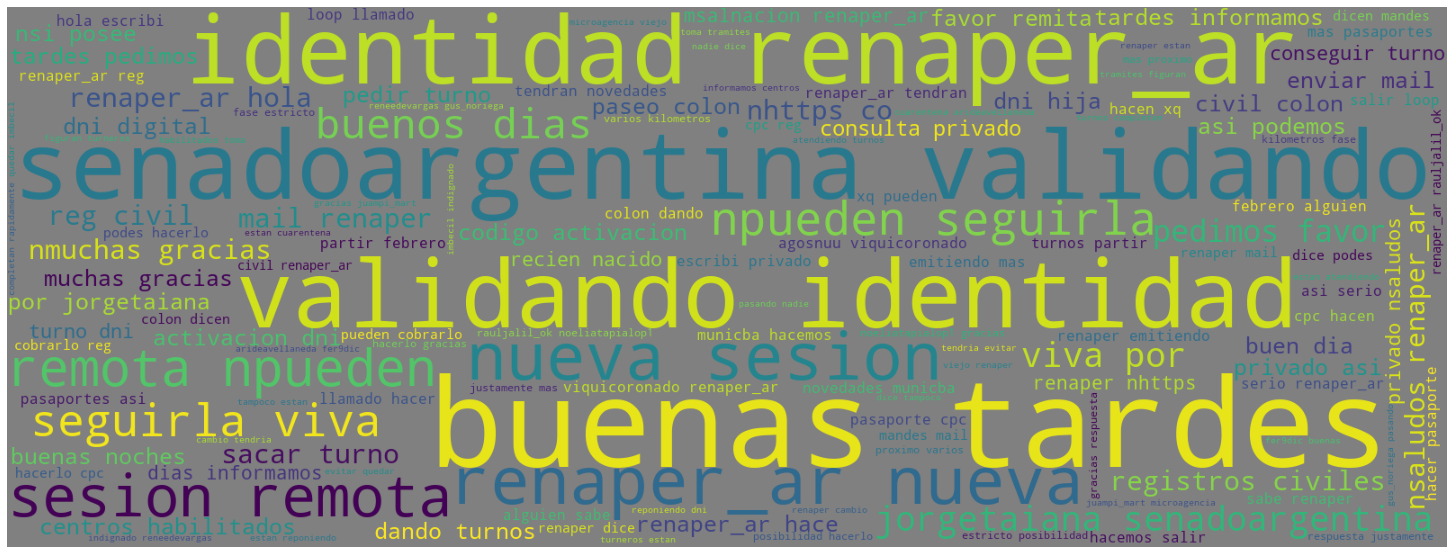

In [111]:
plt.figure(figsize = (20, 10),facecolor = None) 
plt.imshow(wordpos) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
#wordcloud.to_file("img/first_review.png")

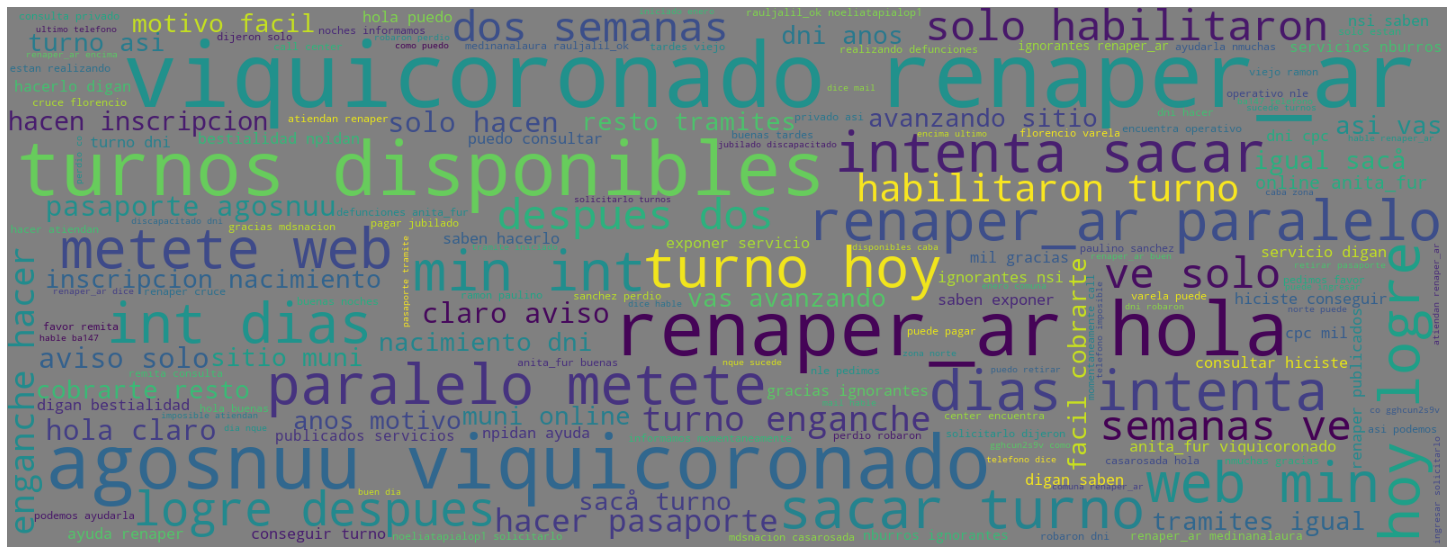

In [112]:
plt.figure(figsize = (20, 10),facecolor = None) 
plt.imshow(wordneg) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

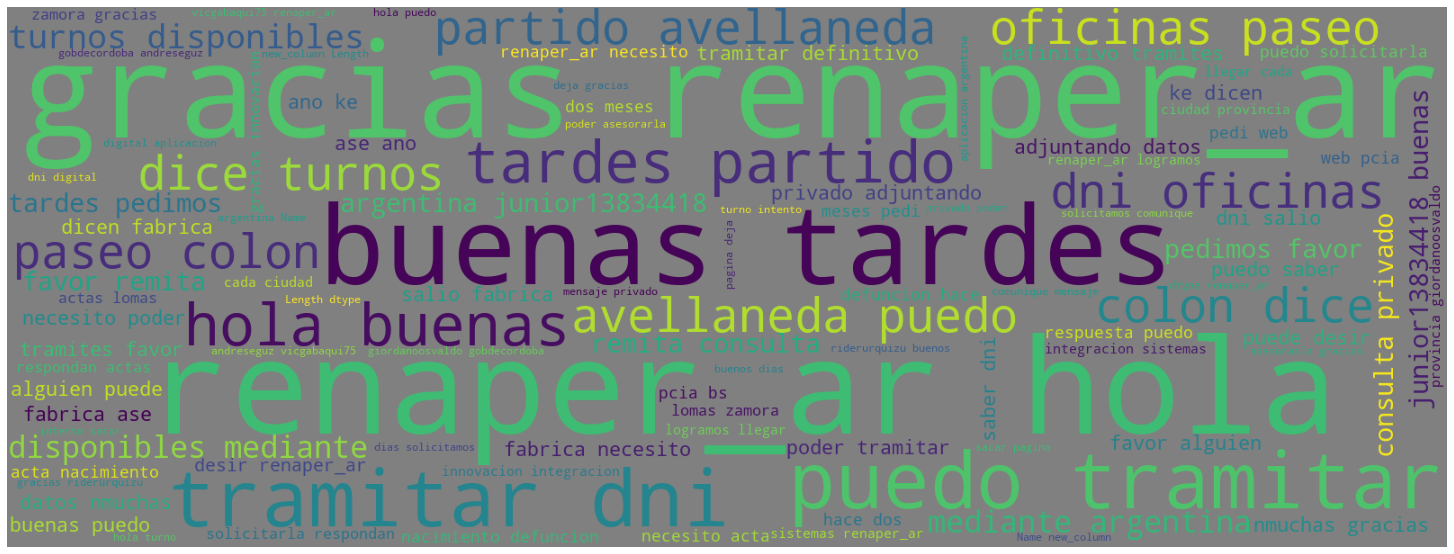

In [113]:
plt.figure(figsize = (20, 10),facecolor = None) 
plt.imshow(wordneu) 
plt.axis("off") 
plt.tight_layout(pad = 0) 